# Neural Ordinary Differential Equations

A significant portion of processes can be described by differential equations: let it be evolution of physical systems, medical conditions of a patient, fundamental properties of markets, etc. Such data is sequential and continuous in its nature, meaning that observations are merely realizations of some continuously changing state.

There is also another type of sequential data that is discrete – NLP data, for example: its state changes discretely, from one symbol to another, from one word to another.

Today both these types are normally processed using recurrent neural networks. They are, however, essentially different in their nature, and it seems that they should be treated differently.

At the last NIPS conference a very interesting [paper](https://arxiv.org/abs/1806.07366) was presented that attempts to tackle this problem. Authors propose a very promising approach, which they call **Neural Ordinary Differential Equations**.

Here I tried to reproduce and summarize the results of original paper, making it a little easier to familiarize yourself with the idea. As I believe, this new architecture may soon be, among convolutional and recurrent networks, in a toolbox of any data scientist.

Imagine a problem: there is a process following an unknown ODE and some (noisy) observations along its trajectory

$$
\frac{dz}{dt} = f(z(t), t) \tag{1}
$$
$$
\{(z_0, t_0),(z_1, t_1),...,(z_M, t_M)\} - \text{observations}
$$

Is it possible to find an approximation $\widehat{f}(z, t, \theta)$ of dynamics function $f(z, t)$?


First, consider a somewhat simpler task: there are only 2 observations, at the beginning and at the end of the trajectory, $(z_0, t_0), (z_1, t_1)$. One starts the evolution of the system from $z_0, t_0$ for time $t_1 - t_0$ with some parameterized dynamics function using any ODE initial value solver. After that, one ends up being at some new state $\hat{z_1}, t_1$, compares it with the observation $z_1$, and tries to minimize the difference by varying the parameters $\theta$.

Or, more formally, consider optimizing the following loss function $L(\hat{z_1})$:

$$
L(z(t_1)) = L \Big( \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big) \tag{2}
$$

<img src=assets/backprop.png width=600></img>

<p style="text-align: center">Figure 1: Continuous backpropagation of the gradient requires solving the augmented ODE backwards in time. <br /> Arrows represent adjusting backpropagated gradients with gradients from observations. <br />
Figure from the original paper</p>

In case you don't want to dig into the maths, the above figure representes what is going on. Black trajectory represents solving the ODE during forward propagation. Red arrows represent solving the adjoint ODE during backpropagation.

To optimize $L$ one needs to compute the gradients wrt. its parameters: $z(t_0), t_0, t_1, \theta$. To do this let us first determine how loss depends on the state at every moment of time $(z(t))$:
$$
a(t) = -\frac{\partial L}{\partial z(t)} \tag{3}
$$
$a(t)$ is called *adjoint*, its dynamics is given by another ODE, which can be thought of as an instantaneous analog of the chain rule

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} \tag{4}
$$
Actual derivation of this particular formula can be found in the appendix of the original paper.

All vectors here are considered row vectors, whereas the original paper uses both column and row representations.

One can then compute 
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{5}
$$

To compute the gradients wrt. to $t$ and $\theta$ one can think of them as if they were part of the augmented state

$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

Adjoint state to this augmented state is then
$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

Gradient of the augmented dynamics

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix} 
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

Adjoint state ODE from formula (4) is then 
$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

By solving this adjoint augmented ODE initial value problem one gets
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{10}
$$

$$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt \tag{11}
$$

$$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt \tag{12}
$$

which, together with,
$$
\frac{\partial L}{\partial t_1} = - a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} \tag{13}
$$
complements gradients wrt. all the ODESolve parameters.

The gradients (10), (11), (12), (13) can be calculated altogether during a single call of the ODESolve with augmented state dynamics (9).

<img src=assets/pseudocode.png width=800></img>
<div align="center">Figure from the original paper</div>

The algorithm above describes backpropagation of gradients for the ODE initial value problem with subsequent observations. This algorithm lies in the heart of Neural ODEs.

In case there are many observations along the trajectory, one computes the adjoint augmented ODE dynamics for subsequent observations, adjusting the backpropagated gradients with direct gradients at observation times, as shown above on *figure 1*.

# Implementation 

The code below is my own implementation of the **Neural ODE**. I did it solely for better understanding of what's going on. However it is very close to what is actually implemented in authors' [repository](https://github.com/rtqichen/torchdiffeq). This notebook collects all the code that's necessary for understanding in one place and is slightly more commented. For actual usage and experiments I suggest using authors'  original implementation.

Below is the code if you are interested.

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

Implement any ordinary differential equation initial value solver. For the sake of simplicity it'll be Euler's ODE initial value solver, however any explicit or implicit method will do.

In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters.  In order to not have to specify them by hand for every new architecture, we will use **torch.autograd.grad** method.

In [3]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below incapsulates forward and backward passes of *Neural ODE*. We have to separate it from main ***torch.nn.Module*** because custom backward function can't be implemented inside Module, but can be implemented inside ***torch.autograd.Function***. So this is just a little workaround.

This function underlies the whole Neural ODE method.

In [1]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

NameError: name 'torch' is not defined

Wrap ode adjoint function in **nn.Module** for convenience.

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Application

## _Learning true dynamics function (proof of concept)_

As a proof-of-concept we will now test if Neural ODE can indeed restore true dynamics function using sampled data.

To test this we will specify an ODE, evolve it and sample points on its trajectory, and then restore it.

First, we'll test a simple linear ODE. Dynamics is given with a matrix.

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

Trained function here is also a simple matrix.

The trained function here is also a simple matrix.

![leaning gif](assets/linear_learning.gif)

Next, slighty more sophisticated dynamics (no gif as its learning process is not so satisfying :)).  
Trained function here is MLP with one hidden layer.
![complicated result](assets/comp_result.png)

In [6]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Dynamics is simply given with a matrix.

In [7]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Initial random linear dynamics function to be optimized

In [8]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

More sophisticated dynamics for creating trajectories

In [9]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Dynamics function to be optimized is MLP

In [10]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [11]:
def to_np(x):
    return x.detach().cpu().numpy()

In [12]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [13]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

In [14]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

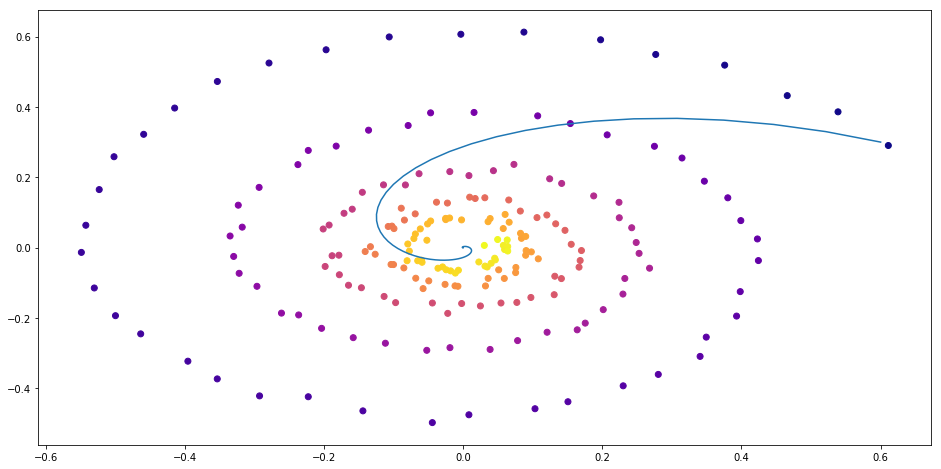

In [15]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [16]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

FileNotFoundError: [Errno 2] No such file or directory: 'assets/imgs/comp/0.png'

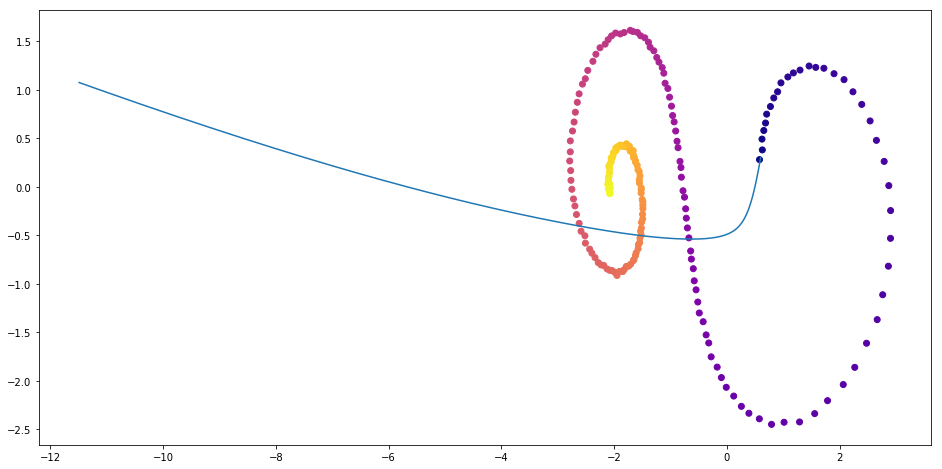

In [17]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

As one can see, Neural ODEs are pretty successful in approximating dynamics. Now let's check if they can be used in a slightly more complicated (MNIST, ha-ha) task.

## Neural ODE inspired by ResNets 

In residual networks hidden state changes according to the formula
$$
h_{t+1} = h_{t} + f(h_{t}, \theta_{t})
$$

where $t \in \{0...T\}$ is residual block number and $f$ is a function learned by layers inside the block.

If one takes a limit of an infinite number of residual blocks with smaller steps one gets continuous dynamics of hidden units to be an ordinary differential equation just as we had above.

$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$

Starting from the input layer $h(0)$, one can deﬁne the output layer $h(T)$ to be the solution to this ODE initial value problem at some time T.

Now one can treat $\theta$ as parameters shared among all infinitesimally small residual blocks.

### Testing Neural ODE architecture on MNIST

In this section we test the ability of Neural ODE's to be used as a component in more conventional architectures. 
In particular, we will use Neural ODE in place of residual blocks in MNIST classifier.

<img src="assets/mnist_example.png" width=400></img>

In [ ]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

```
Testing...
100% 79/79 [00:01<00:00, 45.69it/s]
Test Accuracy: 9.740%

Training Epoch 1...
100% 1875/1875 [01:15<00:00, 24.69it/s]
Train loss: 0.20137
Testing...
100% 79/79 [00:01<00:00, 46.64it/s]
Test Accuracy: 98.680%

Training Epoch 2...
100% 1875/1875 [01:17<00:00, 24.32it/s]
Train loss: 0.05059
Testing...
100% 79/79 [00:01<00:00, 46.11it/s]
Test Accuracy: 97.760%

Training Epoch 3...
100% 1875/1875 [01:16<00:00, 24.63it/s]
Train loss: 0.03808
Testing...
100% 79/79 [00:01<00:00, 45.65it/s]
Test Accuracy: 99.000%

Training Epoch 4...
100% 1875/1875 [01:17<00:00, 24.28it/s]
Train loss: 0.02894
Testing...
100% 79/79 [00:01<00:00, 45.42it/s]
Test Accuracy: 99.130%

Training Epoch 5...
100% 1875/1875 [01:16<00:00, 24.67it/s]
Train loss: 0.02424
Testing...
100% 79/79 [00:01<00:00, 45.89it/s]
Test Accuracy: 99.170%
```

![train error](assets/train_error.png)

After a very rough training procedure of only 5 epochs and 6 minutes of training the model already has test error of less than 1%. Which shows that Neural ODE architecture fits very good as a component in more conventional nets.

In their paper, authors also compare this classifier to simple 1-layer MLP, to ResNet with alike architecture, and to same ODE architecture, but in which gradients propagated directly through ODESolve (without adjoint gradient method) (RK-Net).
!["Methods comparison"](assets/methods_compare.png)
<div align="center">Figure from original paper</div>

According to them, 1-layer MLP with roughly the same amount of parameters as Neural ODE-Net has much higher test error, ResNet with roughly the same error has much more parameters, and RK-Net with direct backpropagation through ODESolver has slightly higher error and linearly growing memory usage.

In their paper, authors use implicit Runge-Kutta solver with adaptive step size instead of simple Euler's method. They also examine some ODE-Net characteristics.

!["Node attrs"](assets/ode_solver_attrs.png)

<div align="center">ODE-Net characteristics (NFE Forward - number of function evaluations during forward pass)</div>
<div align="center">Figure from original paper</div>

- (a) Changing tolerable Numerical Error varies the number of steps per forward pass evaluation.
- (b) Time spent by the forward call is proportional to the number of function evaluations.
- (c) Number of backward evaluations is roughly half the number of forward evaluations, this suggests that adjoint method is more computationally efficient than direct backpropagation through ODESolver.
- (d) As ODE-Net becomes more and more trained, it demands more and more evaluations, presumably adapting to the increasing complexity of the model.

## Generative latent function time-series model

Neural ODE seems to be more suitable for continuous sequential data even when this continuous trajectory is in some unknown latent space.

In this section we will experiment with generating continuous sequential data using Neural ODE and exploring its latent space a bit.
Authors also compare it to the same sequential data but generated with Recurrent Neural Networks.

The approach here is slightly different from the corresponding example in authors repository, the one here has a more diverse set of trajectories.

### Data

Training data consists of random spirals, one half of which is clockwise and another is counter-clockwise. Then, random subtimespans of size 100 are sampled from these spirals, having passed through encoder rnn model in reversed order yielding a latent starting state, which then evolves creating a trajectory in the latent space. This latent trajectory is then mapped onto the data space trajectory and compared with the actual data observations. Thus, the model learns to generate data-alike trajectories.

![image.png](assets/spirals_examples.png)
<div align="center">Examples of spirals in the dataset</div>

### VAE as a generative model

A generative model through sampling procedure:
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
\text{each } x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

Which can be trained using variational autoencoder approach:

1. Run the RNN encoder through the time series backwards in time to infer the parameters $\mu_{z_{t_0}}$, $\sigma_{z_{t_0}}$ of variational posterior and sample from it
$$
z_{t_0} \sim q \left( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q \right) = \mathcal{N} \left(z_{t_0} \mid \mu_{z_{t_0}} \sigma_{z_{t_0}} \right)
$$
2. Obtain the latent trajectory 
$$
z_{t_1}, z_{t_2},...,z_{t_N} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_N), \text{ where } \frac{d z}{d t} = f(z, t; \theta_f)
$$
3. Map the latent trajectory onto the data space using another neural network: $\hat{x_{t_i}}(z_{t_i}, t_i; \theta_x)$
4. Maximize Evidence Lower BOund estimate for sampled trajectory
$$
\text{ELBO} \approx N \Big( \sum_{i=0}^{M} \log p(x_{t_i} \mid z_{t_i}(z_{t_0}; \theta_f); \theta_x) + KL \left( q( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q) \parallel \mathcal{N}(0, I) \right) \Big)
$$
And in case of Gaussian posterior $p(x \mid z_{t_i};\theta_x)$ and known noise level $\sigma_x$
$$
\text{ELBO} \approx -N \Big( \sum_{i=1}^{M}\frac{(x_i - \hat{x_i} )^2}{\sigma_x^2} - \log \sigma_{z_{t_0}}^2 + \mu_{z_{t_0}}^2 + \sigma_{z_{t_0}}^2 \Big) + C
$$

Computation graph of the latent ODE model can be depicted like this
![vae_model](assets/vae_model.png)
<div align="center">Figure from the original paper</div>

One can then test how this model extrapolates the trajectory from only its initial moment observations.

### Defining the models

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

In [ ]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [ ]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

### Generating dataset

In [ ]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [ ]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Training

In [ ]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

In [ ]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [ ]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

This is what I got after a night of training
![spiral reconstruction with seed](assets/spirals_reconstructed.png)
<div align="center">Dots are noisy observations of the original trajectories (blue), <br /> yellow are reconstructed and interpolated trajectories using dots as inputs. <br /> Color of the dots represents time. </div>

Reconstuctions of some examples are not very good. Maybe the model is not complex enough or haven't been trained for a long enough time. Anyway, results look very credible.

Now lets have a look at what happens if we interpolate the latent variable of the clockwise trajectory to another - the counter-clockwise one.
![homotopy](assets/spirals_homotopy.png)

Authors also compare reconstructed trajectories using initial moment of time observations of Neural ODE and simple RNN.
![ode_rnn_comp](assets/ode_rnn_comp.png)
<div align="center">Figure from the original paper</div>

## Continuous normalizing flows

The original paper also contributes a lot in the topic of Normalizing Flows. Normalizing flows are used when one needs to sample from a complicated distribution originating from a change of variables in some simple distribution (e.q. Gaussian), while still being able to know the probability density of each sample.  
They show that using continuous change of variables is much more computationally efficient and interpretable than previous methods._

Normalizing flows are very useful in such models as *Variational AutoEncoders*, *Bayesian Neural Networks* and other things in Bayesian setting.

This topic, however, is beyond the scope of the present notebook, and those interested are adressed to  the original paper.

To tease you a bit:

![CNF_NF_comp](assets/CNF_NF_comp.png)

<div align="center">Visualizing the transformation from noise (simple distribution) to data (complicated distribution) for two datasets; <br /> X-axis represents density and samples transformation with "time" (for CNF) and "depth" (for NF) <br />Figure from the original paper</div>

This concludes my little investigation of **Neural ODEs**. Hope you found it useful!

# Useful links

   - [Original paper](https://arxiv.org/abs/1806.07366)
   - [Authors' PyTorch implementation](https://github.com/rtqichen/torchdiffeq)
   - [Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)
   - [My article on VAE (Russian)](https://habr.com/en/post/331552/)
   - [VAE explained](https://www.jeremyjordan.me/variational-autoencoders/)
   - [More on Normalizing Flows](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
   - [Variational Inference with Normalizing Flows Paper](https://arxiv.org/abs/1505.05770)